In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 23 10:57:41 2025

@author: Paper001
"""
import dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from dataclasses import dataclass

# from utils.data_generation.a_an_data import datasets

import gc
from contextlib import contextmanager
from typing import List, Dict, Optional, Callable
import einops
from tqdm import tqdm

from utils.data import (
    a_an_something_questions,
    a_habit_questions,
    a_rabbit_questions,
    an_ape_questions,
    lines_that_rhyme_with_pain,
    lines_that_rhyme_with_quick,
    example_based_rhymed_prompts_quick,
    example_based_unrhymed_prompts_quick,
    rhymed_couplets,
    unrhymed_couplets,
    lines_that_rhyme_with_rabbit,
    lines_that_rhyme_with_habit,
    lines_that_rhyme_with_rabbit_general,
    lines_that_rhyme_with_rabbit_oneshot,
    lines_that_rhyme_with_habit_general,
    lines_that_rhyme_with_habit_oneshot,
    a_pear_or_an_apple_questions,
    a_pear_questions,
    an_apple_questions,
    a_date_questions,
    a_date_or_a_pear_questions,
)

print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
# %%
dotenv.load_dotenv("hf.env")
# @title 1.5. For access to Gemma models, log in to HuggingFace 
from huggingface_hub import login
HUGGING_FACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")
try:
     login(token=HUGGING_FACE_TOKEN)
     print("Hugging Face login successful (using provided token).")
except Exception as e:
     print(f"Hugging Face login failed. Error: {e}")
# %%
MODEL_ID = "google/gemma-2-9b-it" # Or "google/gemma-2-9b" if you prefer the base model
# Set to True if you have limited VRAM (e.g., < 24GB). Requires bitsandbytes
USE_4BIT_QUANTIZATION = False

POSITIVE_PROMPTS = [
    "This story should be very optimistic and uplifting.",
    "Write a hopeful and positive narrative.",
    "Generate text with a cheerful and encouraging tone.",
]
NEGATIVE_PROMPTS = [
    "This story should be very pessimistic and bleak.",
    "Write a depressing and negative narrative.",
    "Generate text with a gloomy and discouraging tone.",
]

# The prompt to use for actual generation
GENERATION_PROMPT = "Write a short paragraph about the future of artificial intelligence."

# How strongly to apply the steering vector. Tune this value (e.g., 0.5 to 5.0)
STEERING_MULTIPLIER = 1.5

# --- Generation Parameters ---
MAX_NEW_TOKENS = 150
TEMPERATURE = 0.7
DO_SAMPLE = True

PyTorch version: 2.7.0+cu126
Transformers version: 4.51.3
CUDA available: True
CUDA version: 12.6
Current device: 0
Device name: NVIDIA A100-SXM4-80GB


Hugging Face login successful (using provided token).


Token has not been saved to git credential helper.


In [3]:

words_rhyme_quick='''sick, tick, brick, click, trick, kick, thick, pick, stick, lick, flick, slick, wick, prick, chick, nick, clique, hick, shtick, arithmetic, candlestick, dipstick, gimmick, lipstick, maverick, picnic, politic, rhetoric, seasick, sidekick, toothpick, yardstick, Benedict, carsick, chopstick, heretic, homesick, joystick, lunatic, matchstick, nitpick, slapstick, drumstick, kinesthetic, statistic, dramatic, magnetic, Olympic, specific, terrific, acoustic, forensic'''.split()
words_rhyme_quick=[w.strip(',') for w in words_rhyme_quick]

words_rhyme_pain='''rain, main, train, plain, stain, brain, chain, gain, drain, Spain, lane, vain, cane, sane, bane, mane, crane, plane, strain, grain, Maine, Jane, reign, deign, feign, campaign, champagne, cocaine, contain, disdain, domain, explain, humane, inane, insane, maintain, membrane, migraine, mundane, profane, remain, restrain, retain, sustain, terrain, Ukraine, Bahrain, cellophane, entertain, hurricane, microphone, windowpane, abstain, again, arcane, complain, constrain, detain, dingbane, germane, Great Dane, inhumane, insane, mundane, novocaine, obtain, ordain, pertain, propane, refrain, urbane'''.split()
words_rhyme_pain=[w.strip(',') for w in words_rhyme_pain]


pain_rhymes1=[w.split()[-1] for w in lines_that_rhyme_with_pain[:23]]
pain_rhymes2=[w.split()[-1] for w in lines_that_rhyme_with_pain[23:]]

pain_rhymes_from_lines=list(set([w.split()[-1] for w in lines_that_rhyme_with_pain]))
quick_rhymes_from_lines=list(set([w.split()[-1] for w in lines_that_rhyme_with_quick]))

pain_rhymes_outside_lines=[w for w in words_rhyme_pain if w not in pain_rhymes_from_lines]
quick_rhymes_outside_lines=[w for w in words_rhyme_quick if w not in quick_rhymes_from_lines]

pain_rhymes_all=["pain"]+pain_rhymes_from_lines+pain_rhymes_outside_lines
quick_rhymes_all=["quick"]+quick_rhymes_from_lines+quick_rhymes_outside_lines


# %%
# ## 3. Load Model and Tokenizer

# +
# Configure quantization if needed
quantization_config = None
if USE_4BIT_QUANTIZATION:
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16 # Recommended for new models
    )
    print("Using 4-bit quantization.")

# Determine device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float32 # BF16 recommended on Ampere+

print(f"Loading model: {MODEL_ID}")
print(f"Using device: {device}")
print(f"Using dtype: {dtype}")

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token # Set pad token if not present

# Load Model
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=dtype,
    quantization_config=quantization_config,
    # device=device,
    device_map="auto", # Automatically distribute across GPUs if available
    # use_auth_token=YOUR_HF_TOKEN, # Add if model requires authentication
    trust_remote_code=True # Gemma requires this for some versions/variants
)

print(f"Model loaded on device(s): {model.hf_device_map}")

# --- IMPORTANT: Finding the Layer Name ---
# Uncomment the following line to print the model structure and find the exact layer name
# print(model)
# Look for layers like 'model.layers[INDEX].mlp...' or 'model.layers[INDEX].self_attn...'

# Ensure model is in evaluation mode
model.eval()
# %%
# ## 4. Hooking and Activation Handling Functions

# +
# Global storage for captured activations
activation_storage = {}

def get_module_by_name(model, module_name):
    """Helper function to get a module object from its name string."""
    names = module_name.split('.')
    module = model
    for name in names:
        module = getattr(module, name)
    return module

def capture_activation_hook(module, input, output, layer_name):
    """Hook function to capture the output activation of a specific layer."""
    # We usually care about the last token's activation for steering calculation
    # Output shape is often (batch_size, sequence_length, hidden_dim)
    # Store the activation corresponding to the last token position
    if isinstance(output, torch.Tensor):
        activation_storage[layer_name] = output[:, -1, :].detach().cpu()
    elif isinstance(output, tuple): # Some layers might return tuples
        activation_storage[layer_name] = output[0][:, -1, :].detach().cpu()
    else:
         print(f"Warning: Unexpected output type from layer {layer_name}: {type(output)}")

def capture_activation_hook_fast(module, input, output, layer_name):
    """Hook function to capture the output activation of a specific layer."""
    # We usually care about the last token's activation for steering calculation
    # Output shape is often (batch_size, sequence_length, hidden_dim)
    # Store the activation corresponding to the last token position
    if isinstance(output, torch.Tensor):
        activation_storage[layer_name] = output[:, -1, :].detach().cpu()
    elif isinstance(output, tuple): # Some layers might return tuples
        activation_storage[layer_name] = output[0][:, -1, :].detach().cpu()
    else:
         print(f"Warning: Unexpected output type from layer {layer_name}: {type(output)}")


def get_activations_fast(model, tokenizer, prompts: List[str], layer_name: str) -> Optional[torch.Tensor]:
    """
    Runs prompts through the model and captures activations from the target layer.
    Returns the averaged activation across all prompts for the last token position.
    """
    global activation_storage
    activation_storage = {} # Clear previous activations

    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)

    target_module = get_module_by_name(model, layer_name)
    hook_handle = target_module.register_forward_hook(
        lambda module, input, output: capture_activation_hook_fast(module, input, output, layer_name)
    )

    with torch.no_grad():
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(model.device)
        # We only need the forward pass, not generation here
        _ = model(**inputs)

        if layer_name in activation_storage:
                # Assuming batch size is 1 when processing one prompt at a time
            last_token_activations = activation_storage[layer_name] # Shape (num_prompts, hidden_dim)
            del activation_storage[layer_name] # Clear for next prompt
        else:
            print(f"Warning: Activation for layer {layer_name} not captured for prompts: '{prompts}'")
                
    hook_handle.remove() # Clean up the hook

    # Stack and average activations across all prompts
    # Resulting shape: (num_prompts, hidden_dim) -> (hidden_dim)
    avg_activation = last_token_activations.mean(dim=0).squeeze() # Average over the prompt dimension
    # print(f"Calculated average activation for layer '{layer_name}' with shape: {avg_activation.shape}")
    return avg_activation
# %%
 # --- Steering Hook during Generation ---

# Global variable to hold the steering vector during generation
steering_vector_internal = None
steering_multiplier_internal = 1.0

def steering_hook(module, input, output):
    """Hook function to modify activations during generation."""
    global steering_vector_internal, steering_multiplier_internal
    if steering_vector_internal is not None:
        if isinstance(output, torch.Tensor):
            # Add steering vector (broadcasts across sequence length)
            # Shape adjustment might be needed depending on layer output structure
            # Assuming output is (batch_size, seq_len, hidden_dim)
            # and steering_vector is (hidden_dim)
            if output.shape[1] != 1:
                output[:, -1, :] += (steering_vector_internal.to(output.device, dtype=output.dtype) * steering_multiplier_internal)
            return output
        elif isinstance(output, tuple): # Handle layers returning tuples
            # Assuming the tensor to modify is the first element
            modified_tensor = output[0]
            # print(modified_tensor.shape)
            if modified_tensor.shape[1] != 1:
                modified_tensor[:, -1, :] += (steering_vector_internal.to(output[0].device, dtype=output[0].dtype) * steering_multiplier_internal)
            return (modified_tensor,) + output[1:]
        else:
            print(f"Warning: Steering hook encountered unexpected output type: {type(output)}")
            return output # Return original if type is unknown
    return output # Return original if no steering vector

@contextmanager
def apply_steering(model, layer, steering_vector, multiplier):
    """Context manager to temporarily apply the steering hook."""
    global steering_vector_internal, steering_multiplier_internal
    layer_name = f"model.layers.{layer}"

    # Ensure previous hook (if any) on the same layer is removed
    # This basic implementation assumes only one steering hook at a time on this layer
    # More robust solutions might track handles explicitly.
    
    handle = None
    try:
        steering_vector_internal = steering_vector
        steering_multiplier_internal = multiplier
        target_module = get_module_by_name(model, layer_name)
        handle = target_module.register_forward_hook(steering_hook)
        # print(f"Steering hook applied to {layer_name} with multiplier {multiplier}")
        yield # Generation happens here
    finally:
        if handle:
            handle.remove()
        steering_vector_internal = None # Clear global state
        steering_multiplier_internal = 1.0
        # print(f"Steering hook removed from {layer_name}")
        gc.collect() # Suggest garbage collection
        torch.cuda.empty_cache() # Clear cache if using GPU

def generate_steered_output(steering_vector, model, tokenizer, generation_prompt, batch_size, layer=20, steering_multiplier=STEERING_MULTIPLIER):
    inputs = tokenizer([generation_prompt] * batch_size, return_tensors="pt", padding=True).to(model.device)
    if steering_vector is None:
        # print(inputs.input_ids.shape)
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                temperature=TEMPERATURE,
                do_sample=DO_SAMPLE,
                pad_token_id=tokenizer.eos_token_id # Important for generation
            )
    else:
        with torch.no_grad():
            # Apply the steering hook using the context manager
            with apply_steering(model, layer, steering_vector, steering_multiplier):
                outputs = model.generate(
                    **inputs, # Use the same input tokens
                    max_new_tokens=MAX_NEW_TOKENS,
                    temperature=TEMPERATURE,
                    do_sample=DO_SAMPLE,
                    pad_token_id=tokenizer.eos_token_id,
                )
    text = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    del outputs, inputs
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return text

def generate_outputs(steering_vector, model, tokenizer, generation_prompt, batch_size, layer=20, steering_multiplier=STEERING_MULTIPLIER):
    assert steering_vector is not None
    text_baseline = generate_steered_output(None, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    text_steered = generate_steered_output(steering_vector, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    text_negsteered = generate_steered_output(-steering_vector, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    return text_baseline, text_steered, text_negsteered

# %%
# ## Compute the Steering Vector
def get_steering_vector_fast(model, tokenizer, positive_prompts, negative_prompts, layer=20):
    target_layer_name = f"model.layers.{layer}"
    # print("Calculating activations for POSITIVE prompts...")
    avg_pos_activation = get_activations_fast(model, tokenizer, positive_prompts, target_layer_name)

    # print("\nCalculating activations for NEGATIVE prompts...")
    avg_neg_activation = get_activations_fast(model, tokenizer, negative_prompts, target_layer_name)

    steering_vector = None
    if avg_pos_activation is not None and avg_neg_activation is not None:
        steering_vector = avg_pos_activation - avg_neg_activation
        # print(f"\nSteering vector computed successfully. Shape: {steering_vector.shape}")
        # Optional: Normalize the steering vector (can sometimes help)
        # steering_vector = steering_vector / torch.norm(steering_vector)
        # print("Steering vector normalized.")
    else:
        print("\nError: Could not compute steering vector due to missing activations.")
    del avg_pos_activation
    del avg_neg_activation
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    return steering_vector


Loading model: google/gemma-2-9b-it
Using device: cuda
Using dtype: torch.bfloat16


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Model loaded on device(s): {'': 0}


In [4]:
model.device

device(type='cuda', index=0)

In [5]:
# %%
# ## Functions to analyze the generations
def get_last_word(text, num_examples=0, extra_line=True, num_words=1):
    if num_examples > 0:
        if "\n\n" not in text:
            return ""
        return get_last_word(text.split("\n\n")[num_examples], num_examples=0, extra_line=extra_line, num_words=num_words)
    lines = text.split("\n")
    if extra_line:
        lines = lines[1:]
    if len(lines) < 2:
        # print(f"Failed to get last word: {text}")
        return ""
    second_line = lines[1]
    second_line_words = second_line.split(" ")
    second_line_words = [word for word in second_line_words if word != ""]
    if len(second_line_words) == 0:
        # print(f"Failed to get last word: {text}")
        return ""
    last_word = " ".join(second_line_words[-num_words:])
    if last_word == "":
        if len(second_line_words) == 1:
            # print(f"Failed to get last word: {text}")
            return ""
        last_word = " ".join(second_line_words[-num_words-1:])
    return last_word

def get_last_word_fraction(texts, words, num_examples=0, extra_line=True, num_words=1):
    if isinstance(words, str):
        words = [words]
    last_words = [get_last_word(line, num_examples, extra_line=extra_line, num_words=num_words) for line in texts]
    return len([w for w in last_words if any(w2.lower() in w.lower() for w2 in words)]) / len(last_words)

def get_prompts(lines):
    return [f'A rhymed couplet:\n{line}\n' for line in lines]

POSITIVE_PROMPTS = [
    "This story should be very optimistic and uplifting.",
    "Write a hopeful and positive narrative.",
    "Generate text with a cheerful and encouraging tone.",
]
NEGATIVE_PROMPTS = [
    "This story should be very pessimistic and bleak.",
    "Write a depressing and negative narrative.",
    "Generate text with a gloomy and discouraging tone.",
]

# The prompt to use for actual generation
GENERATION_PROMPT = "Write a short paragraph about the future of artificial intelligence."

from tqdm import tqdm
STEERING_MULTIPLIER = 1.5
LAYER = 27
MAX_NEW_TOKENS = 2

In [6]:
MAX_NEW_TOKENS = 5

In [7]:
@dataclass
class SteeringExperimentConfig:
    experiment_name: str
    generation_prompt: str
    positive_prompts: List[str]
    negative_prompts: List[str]
    wordlists: Dict[str, List[str]] = None
    positive_words: List[str] = None
    negative_words: List[str] = None
    layer: int = 27
    batch_size: int = 500
    max_tokens: int = 5
    steering_multiplier: float = 1.5
    save_vectors: bool = False
    num_examples: int = 0
    extra_line: bool = True
    num_words: int = 1

In [8]:
def get_nice_output(rollouts, num_examples=0, extra_line=True):
    lines_list = [rollout.split("\n") for rollout in rollouts]
    num_lines = 2
    if extra_line:
        num_lines += 1
    num_lines = num_lines + (num_lines + 1) * num_examples
    nice_output = ["\n".join(lines[:num_lines]) for lines in lines_list]
    return nice_output

def print_nice_output(rollouts, num_examples=0, extra_line=True, n = 5):
    nice_output = get_nice_output(rollouts, num_examples, extra_line)
    for output in nice_output[:n]:
        print(output)
        print()


In [9]:
def get_statistics(cfg: SteeringExperimentConfig):
    # model, tokenizer, positive_prompts, negative_prompts, generation_prompt, positive_words, negative_words, batch_size=500, layer=27, steering_multiplier=1.5, max_new_tokens=30, one_shot=False
    experiment_name = cfg.experiment_name
    positive_prompts = cfg.positive_prompts
    negative_prompts = cfg.negative_prompts
    generation_prompt = cfg.generation_prompt
    positive_words = cfg.positive_words
    negative_words = cfg.negative_words
    batch_size = cfg.batch_size
    layer = cfg.layer
    steering_multiplier = cfg.steering_multiplier
    num_examples = cfg.num_examples
    extra_line = cfg.extra_line
    num_words = cfg.num_words
    print(f"\nExperiment: {experiment_name}")
    steering_vector = get_steering_vector_fast(model, tokenizer, positive_prompts, negative_prompts, layer)

    """apple_token = tokenizer.encode("apple")[1]
    unembedding_matrix = model.lm_head.weight
    apple_token_unembedding = unembedding_matrix[apple_token]
    steering_vector = apple_token_unembedding / apple_token_unembedding.norm() * steering_vector.norm()"""

    text_unsteered, text_steered, text_negsteered = generate_outputs(steering_vector, model, tokenizer, generation_prompt, batch_size, layer, steering_multiplier)
    print("\nUnsteered:")
    print_nice_output(text_unsteered, num_examples, extra_line)
    print("\nSteered:")
    print_nice_output(text_steered, num_examples, extra_line)
    print("\nNegsteered:")
    print_nice_output(text_negsteered, num_examples, extra_line)
    positive_words_fraction_baseline = get_last_word_fraction(text_unsteered, positive_words, num_examples=num_examples, extra_line=extra_line, num_words=num_words)
    positive_words_fraction_steered = get_last_word_fraction(text_steered, positive_words, num_examples=num_examples, extra_line=extra_line, num_words=num_words)
    positive_words_fraction_negsteered = get_last_word_fraction(text_negsteered, positive_words, num_examples=num_examples, extra_line=extra_line, num_words=num_words)
    negative_words_fraction_baseline = get_last_word_fraction(text_unsteered, negative_words, num_examples=num_examples, extra_line=extra_line, num_words=num_words)
    negative_words_fraction_steered = get_last_word_fraction(text_steered, negative_words, num_examples=num_examples, extra_line=extra_line, num_words=num_words)
    negative_words_fraction_negsteered = get_last_word_fraction(text_negsteered, negative_words, num_examples=num_examples, extra_line=extra_line, num_words=num_words)
    print()
    print(f"Positive words fraction baseline: {positive_words_fraction_baseline}")
    print(f"Positive words fraction steered: {positive_words_fraction_steered}")
    print(f"Positive words fraction negsteered: {positive_words_fraction_negsteered}")
    print(f"Negative words fraction baseline: {negative_words_fraction_baseline}")
    print(f"Negative words fraction steered: {negative_words_fraction_steered}")
    print(f"Negative words fraction negsteered: {negative_words_fraction_negsteered}")
    return text_unsteered, text_steered, text_negsteered

In [10]:
def get_suggestiveness(lines, word1, word2, batch_size=100, num_examples=0, extra_line=True):
    print(batch_size)
    suggestiveness_scores = []
    for prompt in lines:
        couplet = generate_steered_output(None, model, tokenizer, prompt, batch_size)
        suggestiveness_word1 = get_last_word_fraction(couplet, word1, num_examples=num_examples, extra_line=extra_line)
        suggestiveness_word2 = get_last_word_fraction(couplet, word2, num_examples=num_examples, extra_line=extra_line)
        if suggestiveness_word1 == 0 and suggestiveness_word2 == 0:
            continue
        suggestiveness = suggestiveness_word1 - suggestiveness_word2
        suggestiveness_scores.append(suggestiveness)
        print(f"Prompt: {prompt}, Suggestiveness {word1}: {suggestiveness_word1}, Suggestiveness {word2}: {suggestiveness_word2}, Suggestiveness: {suggestiveness}")
    suggestiveness_scores = np.array(suggestiveness_scores)
    return suggestiveness_scores

In [11]:
# one_shot_prompt = "What item uses sand to measure time?\nAn hourglass\n\nHow do you call a person who defends clients in court?\nA lawyer"
one_shot_prompt = "Answer the qustion using the correct article:\nWhat fruit is really sour?\nA lemon\n\nAnswer the qustion using the correct article:\nWhat fruit is guacamole made of?\nAn avocado\n\nAnswer the qustion using the correct article:\n"
one_shot_prompt_the_answer_is = "Answer the qustion using the correct article:\nWhat fruit is really sour?\nThe answer is a lemon\n\nAnswer the qustion using the correct article:\nWhat fruit is guacamole made of?\nThe answer is an avocado\n\nAnswer the qustion using the correct article:\n"
one_shot_prompt_the = "Answer the qustion using the article \"the\":\nWhat fruit is really sour?\nThe lemon\n\nAnswer the qustion using the article \"the\":\nWhat fruit is guacamole made of?\nThe avocado\n\nAnswer the qustion using the article \"the\":\n"

# one_shot_prompt = "Answer the qustion using the correct article:\n"
a_pear_questions_one_shot = [one_shot_prompt + question for question in a_pear_questions]
an_apple_questions_one_shot = [one_shot_prompt + question for question in an_apple_questions]
a_pear_or_an_apple_questions_one_shot = [one_shot_prompt + question for question in a_pear_or_an_apple_questions]
a_date_questions_one_shot = [one_shot_prompt + question for question in a_date_questions]
a_date_or_a_pear_questions_one_shot = [one_shot_prompt + question for question in a_date_or_a_pear_questions]

a_pear_questions_one_shot_the_answer_is = [one_shot_prompt_the_answer_is + question for question in a_pear_questions]
a_pear_questions_one_shot_the = [one_shot_prompt_the + question for question in a_pear_questions]
an_apple_questions_one_shot_the_answer_is = [one_shot_prompt_the_answer_is + question for question in an_apple_questions]
an_apple_questions_one_shot_the = [one_shot_prompt_the + question for question in an_apple_questions]
a_pear_or_an_apple_questions_one_shot_the_answer_is = [one_shot_prompt_the_answer_is + question for question in a_pear_or_an_apple_questions]
a_pear_or_an_apple_questions_one_shot_the = [one_shot_prompt_the + question for question in a_pear_or_an_apple_questions]
a_date_questions_one_shot_the_answer_is = [one_shot_prompt_the_answer_is + question for question in a_date_questions]
a_date_questions_one_shot_the = [one_shot_prompt_the + question for question in a_date_questions]

a_pear_questions_one_shot_the_answer_is[:3]

['Answer the qustion using the correct article:\nWhat fruit is really sour?\nThe answer is a lemon\n\nAnswer the qustion using the correct article:\nWhat fruit is guacamole made of?\nThe answer is an avocado\n\nAnswer the qustion using the correct article:\nWhat fruit has a distinctive bell shape and is narrower at the stem?\n',
 "Answer the qustion using the correct article:\nWhat fruit is really sour?\nThe answer is a lemon\n\nAnswer the qustion using the correct article:\nWhat fruit is guacamole made of?\nThe answer is an avocado\n\nAnswer the qustion using the correct article:\nWhat fruit is traditionally the first item in the song 'The Twelve Days of Christmas' (a partridge in...)?\n",
 'Answer the qustion using the correct article:\nWhat fruit is really sour?\nThe answer is a lemon\n\nAnswer the qustion using the correct article:\nWhat fruit is guacamole made of?\nThe answer is an avocado\n\nAnswer the qustion using the correct article:\nWhat fruit comes in varieties like Bartlet

In [12]:
a_pear_or_an_apple_questions_one_shot[12]

'Answer the qustion using the correct article:\nWhat fruit is really sour?\nA lemon\n\nAnswer the qustion using the correct article:\nWhat fruit is guacamole made of?\nAn avocado\n\nAnswer the qustion using the correct article:\nWhat fruit might be featured in a still life painting?\n'

In [13]:
a_pear_suggestive_indices = [1, 2, 3, 4, 5, 6, 9, 11]
# array([ 0.02,  0.85,  1.  ,  0.99,  0.79,  0.99,  0.87, -0.86,  0.02, 0.94,  0.3 ,  1.  ,  0.06])
a_pear_questions_one_shot_suggestive = [a_pear_questions_one_shot[i] for i in a_pear_suggestive_indices]
a_pear_questions_one_shot_the_answer_is_suggestive = [a_pear_questions_one_shot_the_answer_is[i] for i in a_pear_suggestive_indices]
a_pear_questions_one_shot_the_suggestive = [a_pear_questions_one_shot_the[i] for i in a_pear_suggestive_indices]

an_apple_suggestive_indices = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14]
# array([1.  , 1.  , 0.3 , 0.82, 1.  , 1.  , 1.  , 0.98, 0.98, 1.  , 1.  , 1.  , 0.73, 1.  , 1.  ])
an_apple_questions_one_shot_suggestive = [an_apple_questions_one_shot[i] for i in an_apple_suggestive_indices]
an_apple_questions_one_shot_the_answer_is_suggestive = [an_apple_questions_one_shot_the_answer_is[i] for i in an_apple_suggestive_indices]
an_apple_questions_one_shot_the_suggestive = [an_apple_questions_one_shot_the[i] for i in an_apple_suggestive_indices]

a_date_suggestive_indices = [0, 1, 2, 3, 4, 5, 6, 7, 11, 12]
# array([-0.99,  0.01, -0.55,  0.74,  0.91, -0.04, -0.49, -0.61, -0.12, 0.08, -0.01, -0.43])
a_date_questions_one_shot_suggestive = [a_date_questions_one_shot[i] for i in a_date_suggestive_indices]
a_date_questions_one_shot_the_answer_is_suggestive = [a_date_questions_one_shot_the_answer_is[i] for i in a_date_suggestive_indices]
a_date_questions_one_shot_the_suggestive = [a_date_questions_one_shot_the[i] for i in a_date_suggestive_indices]

In [14]:
model.device

device(type='cuda', index=0)

In [15]:
cfg_an_apple_to_a_pear_1_5 = SteeringExperimentConfig(
    experiment_name='an_apple_to_a_pear',
    generation_prompt=a_pear_or_an_apple_questions_one_shot_the[12],
    positive_prompts=a_pear_questions_one_shot_suggestive,
    negative_prompts=an_apple_questions_one_shot_suggestive,
    positive_words=["the pear"],
    negative_words=["the apple"],
    layer=34,
    steering_multiplier=5.0,
    num_examples=2,
    extra_line=True,
    batch_size=200,
    num_words=2,
)

cfg_a_pear_to_a_date_1_5 = SteeringExperimentConfig(
    experiment_name='a_pear_to_a_date',
    generation_prompt=a_date_or_a_pear_questions_one_shot[-2],
    positive_prompts=a_date_questions_one_shot_suggestive,
    negative_prompts=a_pear_questions_one_shot_suggestive,
    positive_words=["date"],
    negative_words=["pear"],
    layer=28,
    steering_multiplier=1.5,
    num_examples=2,
    extra_line=True,
    batch_size=200,
)

cfg_a_date_to_a_pear_1_5 = SteeringExperimentConfig(
    experiment_name='a_date_to_a_pear',
    generation_prompt=a_date_or_a_pear_questions_one_shot[6],
    positive_prompts=a_pear_questions_one_shot_suggestive,
    negative_prompts=a_date_questions_one_shot_suggestive,
    positive_words=["pear"],
    negative_words=["date"],
    layer=31,
    steering_multiplier=7.0,
    num_examples=2,
    extra_line=True,
    batch_size=200,
)

cfg_a_pear_to_an_apple_1_5 = SteeringExperimentConfig(
    experiment_name='a_pear_to_an_apple',
    generation_prompt="A rhyming couplet:\nI climbed the tree without a care,\nTo grab",
    positive_prompts=an_apple_questions_one_shot_suggestive,
    negative_prompts=a_pear_questions_one_shot_suggestive,
    positive_words=["apple"],
    negative_words=["pear"],
    layer=29,
    steering_multiplier=1.5,
    num_examples=0,
    extra_line=True,
    batch_size=200,
)

# text_unsteered_a_pear_to_an_apple, text_steered_a_pear_to_an_apple, text_negsteered_a_pear_to_an_apple = get_statistics(cfg_a_pear_to_an_apple_1_5)
# text_unsteered_a_date_to_a_pear, text_steered_a_date_to_a_pear, text_negsteered_a_date_to_a_pear = get_statistics(cfg_a_date_to_a_pear_1_5)
# text_unsteered_a_pear_to_a_date, text_steered_a_pear_to_a_date, text_negsteered_a_pear_to_a_date = get_statistics(cfg_a_pear_to_a_date_1_5)
# text_unsteered_an_apple_to_a_pear, text_steered_an_apple_to_a_pear, text_negsteered_an_apple_to_a_pear = get_statistics(cfg_an_apple_to_a_pear_1_5)

In [16]:
# save steering vector
steering_vector = get_steering_vector_fast(model, tokenizer, a_pear_questions_one_shot_suggestive, an_apple_questions_one_shot_suggestive, 29)
torch.save(steering_vector, "steering_vectors/steering_vector_an_apple_to_a_pear_layer_29.pt")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [17]:
a_pear_or_an_apple_questions_one_shot[12]

'Answer the qustion using the correct article:\nWhat fruit is really sour?\nA lemon\n\nAnswer the qustion using the correct article:\nWhat fruit is guacamole made of?\nAn avocado\n\nAnswer the qustion using the correct article:\nWhat fruit might be featured in a still life painting?\n'

In [18]:
a_pear_or_an_apple_questions_one_shot_the[12]

'Answer the qustion using the article "the":\nWhat fruit is really sour?\nThe lemon\n\nAnswer the qustion using the article "the":\nWhat fruit is guacamole made of?\nThe avocado\n\nAnswer the qustion using the article "the":\nWhat fruit might be featured in a still life painting?\n'

In [19]:
a_date_or_a_pear_questions_one_shot[6]

'Answer the qustion using the correct article:\nWhat fruit is really sour?\nA lemon\n\nAnswer the qustion using the correct article:\nWhat fruit is guacamole made of?\nAn avocado\n\nAnswer the qustion using the correct article:\nWhat fruit is sometimes used as a natural sugar substitute in recipes?\n'

In [20]:
print("hello")

hello


In [21]:
# get token for apple

In [22]:
!mkdir steering_vectors

mkdir: cannot create directory ‘steering_vectors’: File exists


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [36]:

def analyze_layers_for_wordlists(model, tokenizer, negative_prompts_list, positive_prompts, 
                               generation_prompt, wordlists_dict, 
                               num_layers=1, batch_size=500, steering_multiplier=1.0,save_vectors=False, num_examples=0, extra_line=True, num_words=1):
    """
    Analyze steering effects across layers for multiple wordlists and negative prompts.
    
    Args:
        model: The language model
        tokenizer: The tokenizer for the model
        negative_prompts_list: List of negative prompts variants for steering
        positive_prompts: Positive prompts for steering
        generation_prompt: The prompt to generate completions from
        wordlists_dict: Dictionary of wordlists to analyze {name: wordlist}
        num_layers: Number of layers to analyze
        batch_size: batch_size
        steering_multiplier: Multiplier for steering vector
        num_examples: Number of examples provided in the prompt (zero-shot, one-shot, two-shot, etc.)
        num_words: Number of words to consider in the last word
    Returns:
        DataFrame with analysis results
    """
    results = []
    
    for neg_prompt_idx, negative_prompts in enumerate(negative_prompts_list):
        neg_prompt_name = f"neg_prompt_v{neg_prompt_idx+1}"
        print(f"Processing negative prompt variant: {neg_prompt_name}")
        
        for layer in tqdm(range(num_layers), desc=f"Analyzing layers for {neg_prompt_name}"):
            # print(f"Layer {layer}")
            
            # Get steering vector for this layer with current negative prompt variant
            steering_vector = get_steering_vector_fast(
                model, tokenizer, negative_prompts, positive_prompts, layer=layer
            )

            if save_vectors: torch.save(steering_vector,f"steering_vectors_quick_to_pain/steering_vector_quick_to_pain_layer_{layer}.pt")
            
            # Generate text with positive and negative steering
            steered_text = generate_steered_output(
                steering_vector, model, tokenizer, generation_prompt, 
                batch_size, layer=layer, steering_multiplier=steering_multiplier
            )
            
            negsteered_text = generate_steered_output(
                -steering_vector, model, tokenizer, generation_prompt, 
                batch_size, layer=layer, steering_multiplier=steering_multiplier
            )
            
            # Analyze each wordlist
            for wordlist_name, wordlist in wordlists_dict.items():
                # Get fractions for positive steering
                pos_fraction = get_last_word_fraction(steered_text, wordlist, num_examples=num_examples, extra_line=extra_line, num_words=num_words)
                
                # Get fractions for negative steering
                neg_fraction = get_last_word_fraction(negsteered_text, wordlist, num_examples=num_examples, extra_line=extra_line, num_words=num_words)
                
                # Store results
                results.append({
                    "layer": layer,
                    "wordlist": wordlist_name,
                    "steering": "positive",
                    "neg_prompt_variant": neg_prompt_name,
                    "last_word_fraction": pos_fraction
                })
                
                results.append({
                    "layer": layer,
                    "wordlist": wordlist_name,
                    "steering": "negative",
                    "neg_prompt_variant": neg_prompt_name,
                    "last_word_fraction": neg_fraction
                })
    
    # Convert to DataFrame
    return pd.DataFrame(results)

def plot_layer_analysis(results_df):
    """
    Plot the results of layer analysis with multiple negative prompt variants.
    
    Args:
        results_df: DataFrame with analysis results
    """
    wordlists = results_df["wordlist"].unique()
    neg_prompt_variants = results_df["neg_prompt_variant"].unique()
    
    # Create figure with subplots - one row per wordlist
    fig, axes = plt.subplots(nrows=len(wordlists), figsize=(14, 5*len(wordlists)))
    if len(wordlists) == 1:
        axes = [axes]  # Make iterable for single subplot
    
    # Colors for different variants
    colors = ['blue', 'green', 'purple', 'orange', 'brown', 'pink']
    
    # Plot each wordlist in its own subplot
    for i, wordlist in enumerate(wordlists):
        wordlist_data = results_df[results_df["wordlist"] == wordlist]
        
        for v_idx, variant in enumerate(neg_prompt_variants):
            variant_data = wordlist_data[wordlist_data["neg_prompt_variant"] == variant]
            
            # Get positive and negative steering data for this variant
            pos_data = variant_data[variant_data["steering"] == "positive"]
            neg_data = variant_data[variant_data["steering"] == "negative"]
            
            # Plot with distinct colors and markers for each variant
            color = colors[v_idx % len(colors)]
            axes[i].plot(pos_data["layer"], pos_data["last_word_fraction"], 
                        label=f"{variant} - Positive", marker='o', linestyle='-', color=color)
            axes[i].plot(neg_data["layer"], neg_data["last_word_fraction"], 
                        label=f"{variant} - Negative", marker='x', linestyle='--', color=color)
        
        axes[i].set_title(f"Wordlist: {wordlist}")
        axes[i].set_xlabel("Layer")
        axes[i].set_ylabel("Last Word Fraction")
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_comparative_analysis(results_df):
    """
    Plot comparison between negative prompt variants for each wordlist.
    
    Args:
        results_df: DataFrame with analysis results
    """
    wordlists = results_df["wordlist"].unique()
    neg_prompt_variants = results_df["neg_prompt_variant"].unique()
    
    if len(neg_prompt_variants) < 2:
        print("Need at least 2 negative prompt variants for comparison")
        return None
    
    # Create a figure with 2 rows per wordlist (pos and neg steering)
    fig, axes = plt.subplots(
        nrows=2*len(wordlists), 
        figsize=(14, 4*len(wordlists)),
        squeeze=False
    )
    
    for w_idx, wordlist in enumerate(wordlists):
        wordlist_data = results_df[results_df["wordlist"] == wordlist]
        
        # First row: Positive steering comparison
        pos_row = w_idx * 2
        pos_data = wordlist_data[wordlist_data["steering"] == "positive"]
        
        for v_idx, variant in enumerate(neg_prompt_variants):
            variant_pos = pos_data[pos_data["neg_prompt_variant"] == variant]
            axes[pos_row, 0].plot(
                variant_pos["layer"], 
                variant_pos["last_word_fraction"],
                label=variant,
                marker='o' if v_idx == 0 else 'x'
            )
        
        axes[pos_row, 0].set_title(f"{wordlist} - Positive Steering Comparison")
        axes[pos_row, 0].set_xlabel("Layer")
        axes[pos_row, 0].set_ylabel("Last Word Fraction")
        axes[pos_row, 0].legend()
        axes[pos_row, 0].grid(True, alpha=0.3)
        
        # Second row: Negative steering comparison
        neg_row = w_idx * 2 + 1
        neg_data = wordlist_data[wordlist_data["steering"] == "negative"]
        
        for v_idx, variant in enumerate(neg_prompt_variants):
            variant_neg = neg_data[neg_data["neg_prompt_variant"] == variant]
            axes[neg_row, 0].plot(
                variant_neg["layer"], 
                variant_neg["last_word_fraction"],
                label=variant,
                marker='o' if v_idx == 0 else 'x'
            )
        
        axes[neg_row, 0].set_title(f"{wordlist} - Negative Steering Comparison")
        axes[neg_row, 0].set_xlabel("Layer")
        axes[neg_row, 0].set_ylabel("Last Word Fraction")
        axes[neg_row, 0].legend()
        axes[neg_row, 0].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

In [37]:
from dataclasses import dataclass

In [ ]:
def save_and_plot_results(results, filename):
    # Save results to CSV for future analysis
    results.to_csv(filename, index=False)
        
        # Plot combined results
    fig1 = plot_layer_analysis(results)
    plt.savefig(filename, dpi=300)
        
        # Plot comparative analysis
    fig2 = plot_comparative_analysis(results)
    plt.savefig(filename, dpi=300)
        
    plt.show()

def run_analysis(cfg: SteeringExperimentConfig):
    print(f"Running analysis for {cfg.experiment_name}")
    results = analyze_layers_for_wordlists(
        model=model,
        tokenizer=tokenizer,
        negative_prompts_list=[cfg.negative_prompts],
        positive_prompts=cfg.positive_prompts,
        generation_prompt=cfg.generation_prompt,
        wordlists_dict=cfg.wordlists,
        num_layers=model.config.num_hidden_layers,
        batch_size=500,
        steering_multiplier=cfg.steering_multiplier,
        save_vectors=cfg.save_vectors,
        num_examples=cfg.num_examples,
        extra_line=cfg.extra_line,
        num_words=cfg.num_words,
    )
    save_and_plot_results(results, f"layer_analysis_results_{cfg.experiment_name}.png")
    return results

In [48]:
MAX_NEW_TOKENS = 5

In [49]:
# Define all the Experiment Configs

# Quick to Pain / (maybe Pain to Quick ...)
cfg_quick_to_pain = SteeringExperimentConfig(
    experiment_name='quick_to_pain',
    generation_prompt='A rhymed couplet:\nA leopard appeared, fierce and quick\n',
    positive_prompts=get_prompts(lines_that_rhyme_with_quick),
    negative_prompts=get_prompts(lines_that_rhyme_with_pain),
    wordlists={
        "all_quick_rhymes": quick_rhymes_all,
        "all_pain_rhymes": pain_rhymes_all,
        "quick": ["quick"],
        "stick": ["stick"],
        "trick": ["trick"],
        "rain": ["rain"],
        "pain": ["pain"],
        "crane": ["crane"],
    }
)

# Rabbit to Habit Cheating
cfg_rabbit_to_habit_cheating = SteeringExperimentConfig(
    experiment_name='rabbit_to_habit_cheating',
    generation_prompt='A rhymed couplet:\nHe saw a carrot and had to grab it\n',
    positive_prompts=[f"A rhymed couplet that ends with rabbit:\n{line}" for line in lines_that_rhyme_with_rabbit_general],
    negative_prompts=[f"A rhymed couplet that ends with habit:\n{line}" for line in lines_that_rhyme_with_habit_general],
    wordlists={
        "rabbit": ["rabbit"],
        "habit": ["habit"],
    }
)

# Rabbit to Habit Oneshot
cfg_rabbit_to_habit_oneshot = SteeringExperimentConfig(
    experiment_name='rabbit_to_habit_oneshot',
    generation_prompt='A rhymed couplet:\nHe saw a carrot and had to grab it\n',
    positive_prompts=lines_that_rhyme_with_rabbit_oneshot,
    negative_prompts=lines_that_rhyme_with_habit_oneshot,
    wordlists={
        "rabbit": ["rabbit"],
        "habit": ["habit"],
    }
)

# Quick to unrhymed
cfg_quick_to_unrhymed = SteeringExperimentConfig(
    experiment_name='quick_to_unrhymed',
    generation_prompt=example_based_unrhymed_prompts_quick[10],
    positive_prompts=example_based_unrhymed_prompts_quick,
    negative_prompts=example_based_rhymed_prompts_quick,
    wordlists={
        "all_quick_rhymes": quick_rhymes_all,
        "all_pain_rhymes": pain_rhymes_all,
        "quick": ["quick"],
        "stick": ["stick"],
        "trick": ["trick"],
        "rain": ["rain"],
        "pain": ["pain"],
        "mane": ["mane"],
    },
    num_examples=1,
    extra_line=False,
)

one_shot_prompt = "Uses sand to measure time:\nAn hourglass"
rabbit_one_shot_prompts = [one_shot_prompt + "\n\n" + line for line in a_rabbit_questions]
habit_one_shot_prompts = [one_shot_prompt + "\n\n" + line for line in a_habit_questions]
ape_one_shot_prompts = [one_shot_prompt + "\n\n" + line for line in an_ape_questions]

# a / an generalization
cfg_a_an_generalization = SteeringExperimentConfig(
    experiment_name='a_an_generalization',
    generation_prompt='A rhymed couplet:\nHe saw a carrot and had to grab it\n',
    positive_prompts=rabbit_one_shot_prompts,
    negative_prompts=habit_one_shot_prompts,
    wordlists={
        "rabbit": ["rabbit"],
        "habit": ["habit"],
    },
    num_examples=0,
)

a_rabbit_questions_and_article_one_shot = [line + "A " for line in rabbit_one_shot_prompts]
a_habit_questions_and_article_one_shot = [line + "A " for line in habit_one_shot_prompts]
an_ape_questions_and_article_one_shot = [line + "An " for line in ape_one_shot_prompts]

# a / an generalization with article
cfg_a_an_generalization_with_article = SteeringExperimentConfig(
    experiment_name='a_an_generalization_with_article',
    generation_prompt='A rhymed couplet:\nHe saw a carrot and had to grab it\n',
    positive_prompts=a_rabbit_questions_and_article_one_shot,
    negative_prompts=a_habit_questions_and_article_one_shot,
    wordlists={
        "rabbit": ["rabbit"],
        "habit": ["habit"],
    },
    num_examples=0,
)

cfg_brick_to_rain = SteeringExperimentConfig(
    experiment_name='brick_to_rain',
    generation_prompt='A rhymed couplet:\nThe house was built with sturdy, reddish brick\n',
    positive_prompts=get_prompts(lines_that_rhyme_with_pain),
    negative_prompts=get_prompts(lines_that_rhyme_with_quick),
    wordlists = {
        "all_brick_rhymes": quick_rhymes_all,
        "all_rain_rhymes": pain_rhymes_all,
        "quick": ["quick"],
        "trick": ["trick"],
        "pain": ["pain"],
        "rain": ["rain"],
    },
    num_examples=0,
    extra_line=True,
)

cfg_an_apple_to_a_pear_1_5 = SteeringExperimentConfig(
    experiment_name='an_apple_to_a_pear',
    generation_prompt=a_pear_or_an_apple_questions_one_shot[12],
    positive_prompts=a_pear_questions_one_shot_suggestive,
    negative_prompts=an_apple_questions_one_shot_suggestive,
    # positive_words=["pear"],
    # negative_words=["apple"],
    # layer=27,
    steering_multiplier=1.5,
    num_examples=2,
    extra_line=True,
    # batch_size=200,
    wordlists={
        "apple": ["apple"],
        "pear": ["pear"],
    }
)

cfg_a_date_to_a_pear_1_5 = SteeringExperimentConfig(
    experiment_name='a_date_to_a_pear',
    generation_prompt=a_date_or_a_pear_questions_one_shot[6],
    positive_prompts=a_pear_questions_one_shot_suggestive,
    negative_prompts=a_date_questions_one_shot_suggestive,
    steering_multiplier=2.0,
    num_examples=2,
    extra_line=True,
    wordlists={
        "date": ["date"],
        "pear": ["pear"],
    }
)

cfg_an_apple_to_a_pear_the_answer_is_1_5 = SteeringExperimentConfig(
    experiment_name='an_apple_to_a_pear_the_answer_is',
    generation_prompt=a_pear_or_an_apple_questions_one_shot_the_answer_is[12],
    positive_prompts=a_pear_questions_one_shot_the_answer_is_suggestive,
    negative_prompts=an_apple_questions_one_shot_the_answer_is_suggestive,
    # positive_words=["pear"],
    # negative_words=["apple"],
    # layer=27,
    steering_multiplier=5.0,
    num_examples=2,
    extra_line=True,
    batch_size=500,
    wordlists={
        "apple": ["apple"],
        "pear": ["pear"],
    },
    num_words=1,
)

cfg_an_apple_to_a_pear_the_1_5 = SteeringExperimentConfig(
    experiment_name='an_apple_to_a_pear_the',
    generation_prompt=a_pear_or_an_apple_questions_one_shot_the[12],
    positive_prompts=a_pear_questions_one_shot_suggestive,
    negative_prompts=an_apple_questions_one_shot_suggestive,
    # positive_words=["pear"],
    # negative_words=["apple"],
    # layer=27,
    steering_multiplier=5.0,
    num_examples=2,
    extra_line=True,
    batch_size=1000,
    wordlists={
        "the apple": ["the apple"],
        "the pear": ["the pear"],
        "a pear": ["a pear"],
        "an apple": ["an apple"],
    },
    num_words=2,
)

cfg_an_apple_to_a_pear_the_1_5_no_generalization = SteeringExperimentConfig(
    experiment_name='an_apple_to_a_pear_the_1_5_no_generalization',
    generation_prompt=a_pear_or_an_apple_questions_one_shot_the[12],
    positive_prompts=a_pear_questions_one_shot_the_suggestive,
    negative_prompts=an_apple_questions_one_shot_the_suggestive,
    # positive_words=["pear"],
    # negative_words=["apple"],
    # layer=27,
    steering_multiplier=5.0,
    num_examples=2,
    extra_line=True,
    batch_size=1000,
    wordlists={
        "the apple": ["the apple"],
        "the pear": ["the pear"],
    },
    num_words=2,
)


In [50]:
MAX_NEW_TOKENS = 5

Running analysis for an_apple_to_a_pear_the_answer_is
Processing negative prompt variant: neg_prompt_v1


Analyzing layers for neg_prompt_v1: 100%|██████████| 1/1 [00:24<00:00, 24.33s/it]


Need at least 2 negative prompt variants for comparison


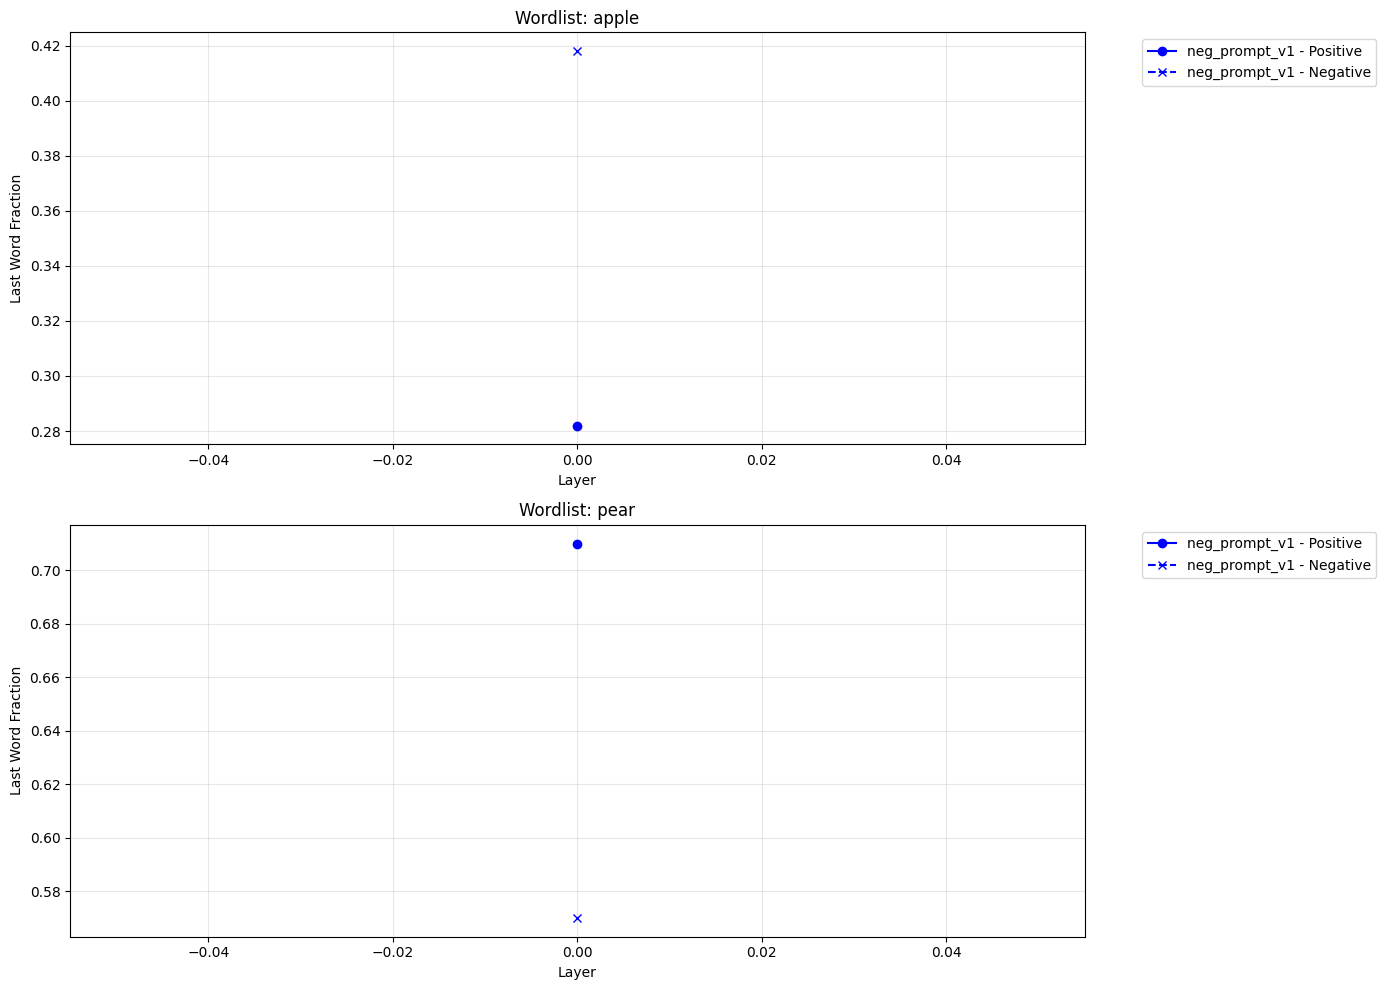

,layer,wordlist,steering,neg_prompt_variant,last_word_fraction
0,0,apple,positive,neg_prompt_v1,0.282
1,0,apple,negative,neg_prompt_v1,0.418
2,0,pear,positive,neg_prompt_v1,0.710
3,0,pear,negative,neg_prompt_v1,0.570


In [51]:
# cfg_quick_to_pain, cfg_rabbit_to_habit_cheating, cfg_rabbit_to_habit_oneshot, cfg_quick_to_unrhymed, cfg_rhyming_to_unrhyming, cfg_a_an_generalization, cfg_a_an_generalization_with_article
# run_analysis(cfg_quick_to_pain)
# run_analysis(cfg_rabbit_to_habit_cheating)
# run_analysis(cfg_rabbit_to_habit_oneshot)
# run_analysis(cfg_quick_to_unrhymed)
# run_analysis(cfg_rhyming_to_unrhyming)
# run_analysis(cfg_a_an_generalization)
# run_analysis(cfg_a_an_generalization_with_article)
# run_analysis(cfg_brick_to_rain)
# run_analysis(cfg_an_apple_to_a_pear_1_5)
# run_analysis(cfg_a_date_to_a_pear_1_5)
# run_analysis(cfg_an_apple_to_a_pear_the_answer_is_1_5)
# run_analysis(cfg_an_apple_to_a_pear_the_1_5)
# run_analysis(cfg_an_apple_to_a_pear_the_1_5_no_generalization)
run_analysis(cfg_an_apple_to_a_pear_the_answer_is_1_5)

In [32]:
generation_prompt=a_pear_or_an_apple_qustions_one_shot[12]